In [1]:
%matplotlib inline
import sys
BIN = '../../'
sys.path.append(BIN)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
#import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

import my_matplotlib_style as ms

from fastai import data_block, basic_train, basic_data
from fastai.callbacks import ActivationStats
import fastai

import matplotlib as mpl
mpl.rc_file(BIN + 'my_matplotlib_rcparams')

from nn_utils import AE_big, AE_3D_200
from utils import plot_activations

In [2]:
# Load data
train = pd.read_pickle(BIN + 'processed_data/aod/compressed_all_jets_train.pkl')
test = pd.read_pickle(BIN + 'processed_data/aod/compressed_all_jets_test.pkl')
#n_features = len(train.loc[0])

import matplotlib.pyplot as plt
import numpy as np

plt.close('all')
unit_list = ['[MeV]', '[rad]', '[rad]', '[MeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$',"ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac", "Timing"]
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pt","eta","phi","m","ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt","FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac", "Timing"]

trainplot = train.loc[train["pt"] < 0.25e6]

"""
%matplotlib inline
n_bins = 200
alph = 0.8
#for kk in np.arange(4):
for kk in range(13):
    plt.figure(kk + 4)
    plt.figure(figsize=(6,6))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    n_hist_data, bin_edges, _ = plt.hist(trainplot[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    #plt.xlim(0, 0.25*1e4)
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()
    #plt.savefig("compressed_input_"+branches[kk])
"""

'\n%matplotlib inline\nn_bins = 200\nalph = 0.8\n#for kk in np.arange(4):\nfor kk in range(13):\n    plt.figure(kk + 4)\n    plt.figure(figsize=(6,6))\n    plt.ticklabel_format(style=\'sci\', axis=\'x\', scilimits=(0,0))\n    n_hist_data, bin_edges, _ = plt.hist(trainplot[branches[kk]], color=colors[1], label=\'Input\', alpha=1, bins=n_bins)\n    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label=\'Output\', alpha=alph, bins=bin_edges)\n    #plt.suptitle(branches[kk])\n    plt.xlabel(variable_list[kk])\n    plt.ylabel(\'Number of events\')\n    ms.sciy()\n    #plt.xlim(0, 0.25*1e4)\n    # plt.yscale(\'log\')\n    #plt.legend(loc=4)\n    fig_name = \'trainforever_hist_%s\' % train.columns[kk]\n    plt.tight_layout()\n    #plt.savefig("compressed_input_"+branches[kk])\n'

In [3]:


#Remove zero mass jets

train = train.loc[train["m"] > 0.08]
test = test.loc[test["m"] > 0.08]

#train = train.loc[train["m"] < 15000]
#test = test.loc[test["m"] < 15000]

#train = train.loc[train["pt"] > 10000]
#test = test.loc[test["pt"] > 10000]

#train = train.loc[train["pt"] < 25000]
#test = test.loc[test["pt"] < 25000]

#train = train.loc[train["pt"] > 25000]#.iloc(:1)
#test = test.loc[test["pt"] > 25000]

#Shuffle datasets
train = train.sample(frac=0.05)
test = test.sample(frac=0.05)

"""
def log_normalize(train, test=None):
    train['pt'] = train['pt'].apply(lambda x: x / 1000.)
    train['m'] = train['m'].apply(lambda x: x / 1000.)
    train['eta'] = train['eta'] / 1.
    train['phi'] = train['phi'] / 1.
    if test is not None:
        test['pt'] = test['pt'].apply(lambda x: x / 1000.)
        test['m'] = test['m'].apply(lambda x: x / 1000.)
        test['eta'] = test['eta'] / 1.
        test['phi'] = test['phi'] / 1.

        return train#.astype('float32'), test.astype('float32')
    else:
        return train#.astype('float32')
"""
# Normalize
#log_normalize(train, test)

# Custom normalization for AOD data
eta_div = 5
emfrac_div = 1.6
negE_div = 1.6
phi_div = 3
m_div = 1.8
width_div = .6
N90_div = 20
timing_div = 40
hecq_div = 1
centerlambda_div = 2
secondlambda_div = 1
secondR_div = .6
larqf_div = 2.5
pt_div = 1.2
centroidR_div = 0.8
area4vecm_div = 0.18
area4vecpt_div = 0.7
area4vec_div = 0.8
Oot_div = 0.3
larq_div = 0.6

log_add = 100
log_sub = 2

centroidR_sub = 3

area4vecm_sub = 0.15


m_add = 1
pt_sub = 1.3
eta_div = 5
phi_div = 3

branches = ["ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]

means = [train[k].mean() for k in branches]
stds = [train[k].std() for k in branches]



for data in [train,test]:
    #data['m'] = (np.log10(data['m'])-3.6)
    data['m'] = np.log10(data['m'] + m_add) / m_div -1.4
    data['eta'] = data['eta'] / eta_div
    
    data['phi'] = data['phi'] / phi_div
    
    #data['pt'] = (np.log10(data['pt']/1000-10)) -0.7
    data['pt'] = (np.log10(data['pt']) - pt_sub) / pt_div -2.4
    
    #data['Timing'] = np.log10(data['Timing'])
    
    for k in range(0,len(branches)):
        data[branches[k]] = (data[branches[k]] - means[k])/stds[k]
    
    #data['Timing'] = data['Timing']/50
    
    #data['FracSamplingMaxIndex'] = data['FracSamplingMaxIndex']/20
    


train = train.loc[train["m"] > 0]
test = test.loc[test["m"] > 0]

train = train.drop("JvtRpt",axis=1)
test = test.drop("JvtRpt",axis=1)

del means[6:7]
del stds[6:7]

#train_mean = train.mean()
#train_std = train.std()

#train = (train - train_mean) / train_std
#test = (test - train_mean) / train_std

#train = (train - train_mean)
#test = (test - train_mean) 




train_x = train
test_x = test
train_y = train_x  # y = x since we are building and AE
test_y = test_x

train_ds = TensorDataset(torch.tensor(train_x.values), torch.tensor(train_y.values))
valid_ds = TensorDataset(torch.tensor(test_x.values), torch.tensor(test_y.values))

train.head(10)

,pt,eta,phi,m,ActiveArea4vec_eta,ActiveArea4vec_m,ActiveArea4vec_phi,ActiveArea4vec_pt,Jvt,JVFCorr,FracSamplingMax,FracSamplingMaxIndex,Width,EMFrac,Timing
835969,0.570505,0.251563,0.468750,0.895860,0.573399,-0.668608,0.764121,-0.612579,1.791284,1.143581,0.222310,-0.827689,-0.002168,0.530189,0.139589
981084,0.223045,-0.515625,0.854167,0.604082,-1.274505,0.159793,1.395780,0.339191,-0.625424,-0.266178,-0.534248,0.059850,-0.672892,-1.066638,-0.321051
1481456,0.111697,0.656250,-0.277344,0.554511,1.545981,0.660687,-0.471076,0.584809,-0.869235,-1.782558,-0.862089,1.982851,-0.404603,-1.280118,-0.689214
1156555,0.671443,-0.278125,0.645833,0.765501,-0.705919,-0.071388,1.058318,0.001466,1.810313,1.185045,-0.937745,1.539081,-2.028714,-0.596983,0.183716
694848,0.116165,0.943750,0.822917,0.454366,2.264195,-1.843782,1.369821,-2.178395,-0.869235,-1.782558,2.441547,2.130774,-1.372362,-2.313359,0.233814
166596,0.107173,-0.712500,0.520833,0.457887,-1.745833,-0.302570,0.846323,-0.152045,-0.869235,-1.782558,1.205836,2.130774,-1.640652,-1.860783,0.390808
1509755,0.171636,-0.587500,1.036458,0.575791,-1.424133,0.236854,1.689978,0.154977,-0.869235,-1.782558,2.996356,-0.235997,-0.308785,1.264559,0.369836
1071770,0.055908,-0.571875,0.828125,0.471477,-1.386726,-0.533752,1.361169,-0.459068,-0.869235,-1.782558,-0.256843,0.207773,-0.807037,-2.926580,-3.895493
181971,0.278125,0.459375,0.040365,0.761562,1.082134,0.159793,0.079463,0.154977,-0.249597,0.527552,-1.612343,-0.383920,0.956010,-0.733610,-0.351343
515013,0.131382,0.317188,0.796875,0.662256,0.730509,0.313915,1.309251,0.308488,-0.625424,-0.266178,-1.202540,-0.235997,1.224300,0.496033,0.390808


IndexError: list index out of range

<Figure size 432x288 with 0 Axes>

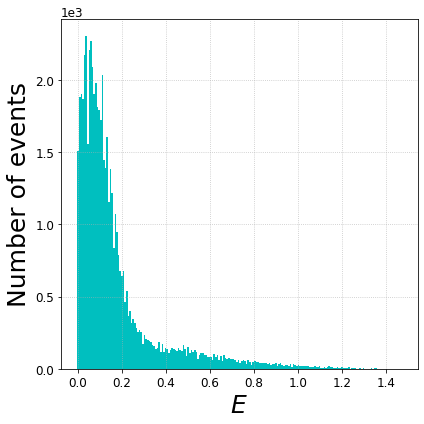

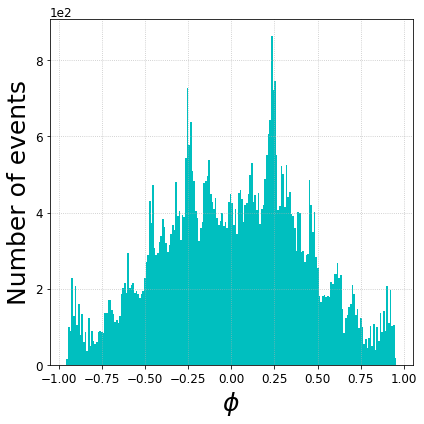

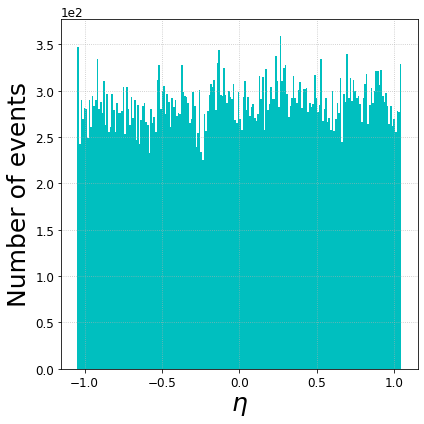

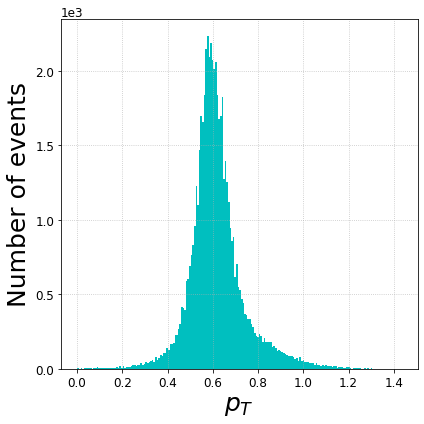

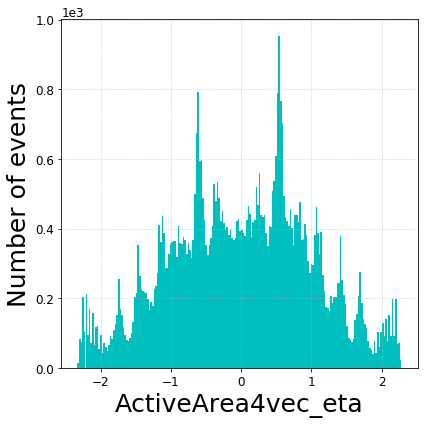

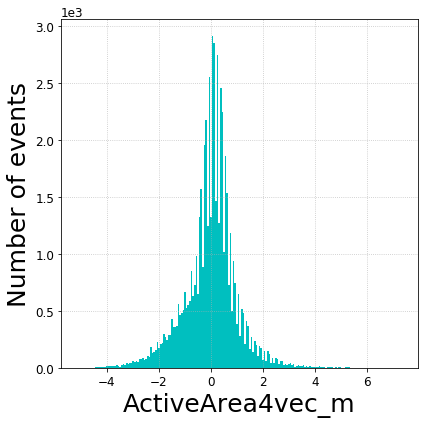

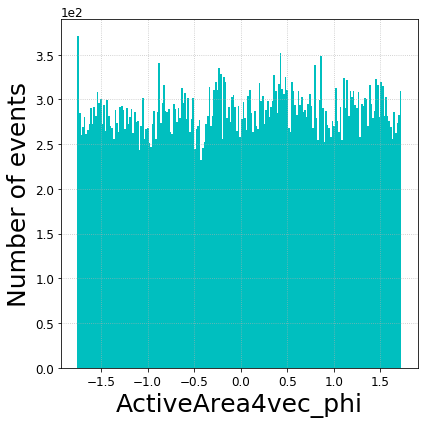

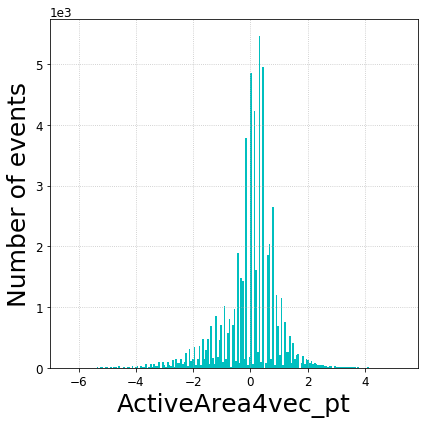

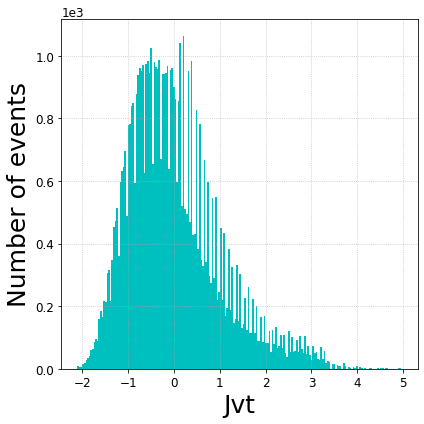

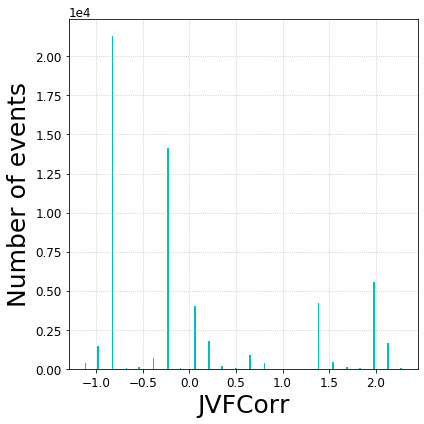

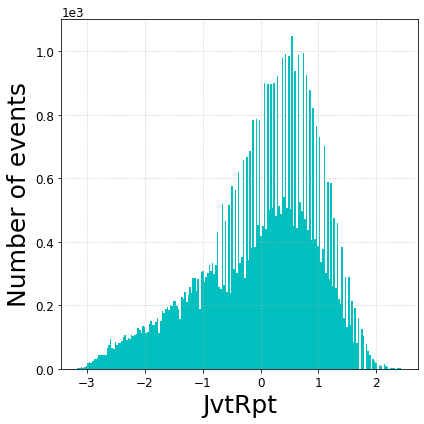

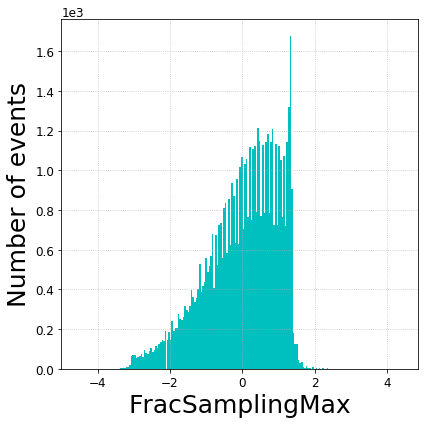

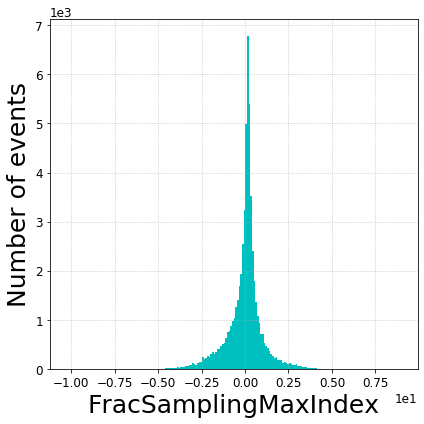

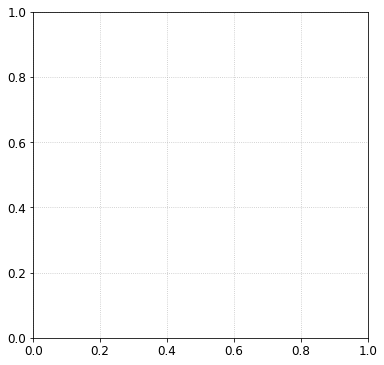

In [12]:
branches=["pt","eta","phi","m","ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac", "Timing"]

#trainplot = train.loc[train["pt"] < 0.25e6]

%matplotlib inline
n_bins = 200
alph = 0.8
#for kk in np.arange(4):
for kk in range(16):
    plt.figure(kk + 4)
    plt.figure(figsize=(6,6))
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    plt.xlabel(variable_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    #plt.xlim(0, 0.25*1e4)
    # plt.yscale('log')
    #plt.legend(loc=4)
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()
    plt.savefig("compressed_15_10_normalized_"+branches[kk])

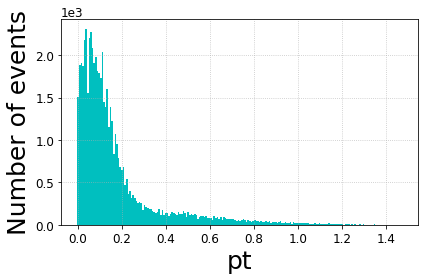

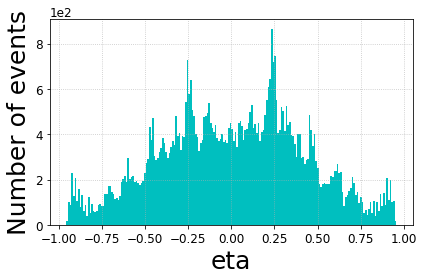

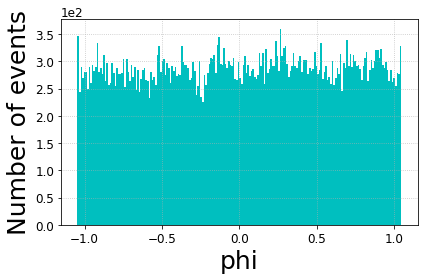

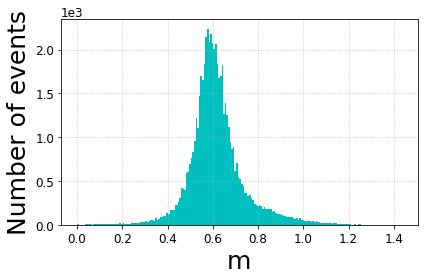

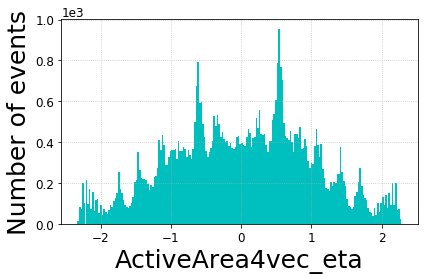

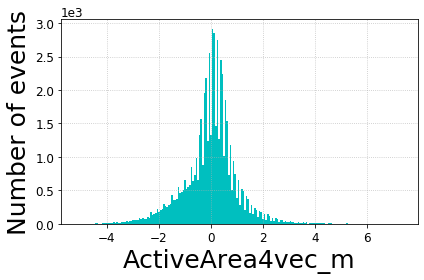

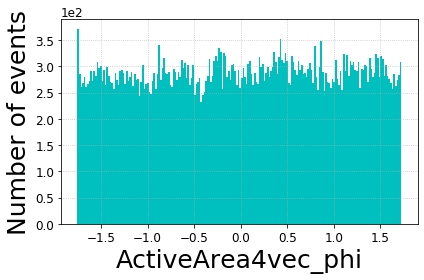

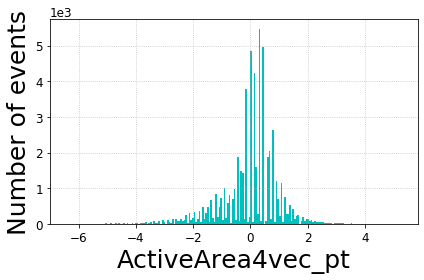

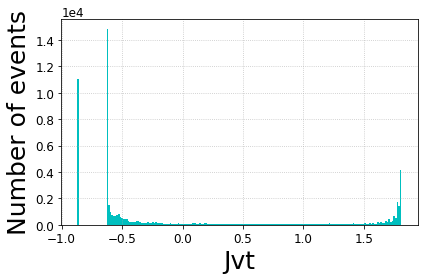

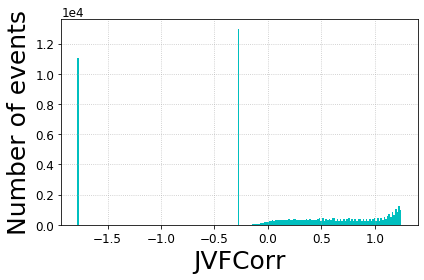

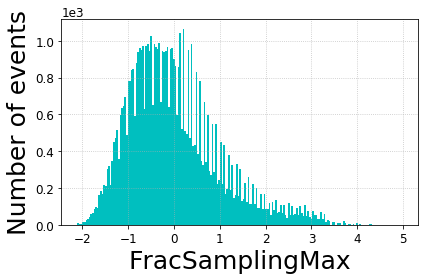

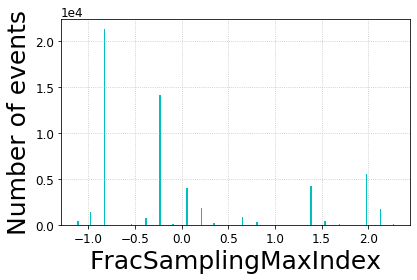

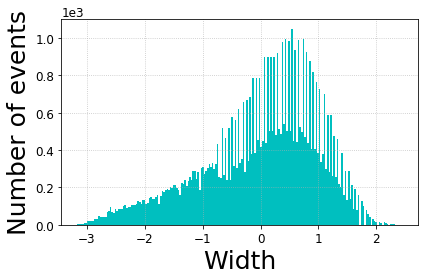

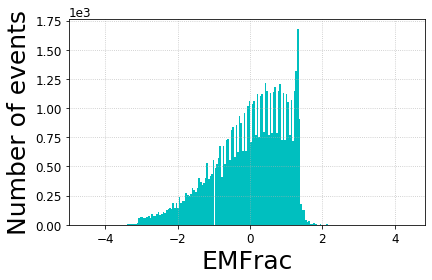

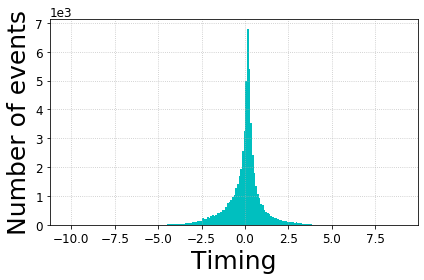

In [18]:
plt.close('all')
unit_list = ['[GeV]', '[rad]', '[rad]', '[GeV]']
variable_list = [r'$p_T$', r'$\eta$', r'$\phi$', r'$m$']
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

branches=["pt","eta","phi","m","ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac", "Timing"]

%matplotlib inline
n_bins = 200
alph = 0.8
for kk in np.arange(15):
    plt.figure(kk + 13)
    n_hist_data, bin_edges, _ = plt.hist(train[branches[kk]], color=colors[1], label='Input', alpha=1, bins=n_bins)
    #n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    #plt.suptitle(branches[kk])
    plt.xlabel(branches[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    # plt.yscale('log')
    #plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    plt.tight_layout()
    plt.savefig("compressed_15_10_normalized_"+str(branches[kk]), dpi=300)

In [8]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs=16)

db = basic_data.DataBunch(train_dl, valid_dl)


class AE_3D_200_wide(nn.Module):
    def __init__(self, n_features=16):
        super(AE_3D_200_wide, self).__init__()
        self.n = 200
        self.en1 = nn.Linear(n_features, self.n)
        self.en2 = nn.Linear(self.n, self.n)
        self.en3 = nn.Linear(self.n, self.n)
        self.en4 = nn.Linear(self.n, 10)
        self.de1 = nn.Linear(10, self.n)
        self.de2 = nn.Linear(self.n, self.n)
        self.de3 = nn.Linear(self.n, self.n)
        self.de4 = nn.Linear(self.n, n_features)
        self.tanh = nn.LeakyReLU()
        

    def encode(self, x):
        return self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))

    def decode(self, x):
        return self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

    def describe(self):
        return 'in-200-200-200-3-200-200-200-out'

model = AE_3D_200_wide(15).double()

#model = AE_3D_200().double()

loss_func = nn.MSELoss()


bn_wd = False  # Don't use weight decay fpr batchnorm layers
true_wd = True  # wd will be used for all optimizers
wd =1e-2
learn = basic_train.Learner(data=db, model=model, loss_func=loss_func, wd=wd, callback_fns=ActivationStats, bn_wd=bn_wd, true_wd=true_wd)

#from fastai import train as tr
#tr.lr_find(learn)

#learn.recorder.plot()

In [5]:
lr = 1e-3
learn.fit(20, lr=lr, wd=wd)

learn.save('compressed_15_300_10_300_15_bs16')

lr = 1e-4
learn.fit(100, lr=lr, wd=wd)

learn.save('compressed_15_300_10_300_15_bs16')



epoch,train_loss,valid_loss,time
0,0.013583,0.014106,01:12
1,0.010898,0.009967,01:12
2,0.009110,0.008407,01:11
3,0.007966,0.007847,01:11
4,0.006274,0.006239,01:12
5,0.005428,0.005623,01:11
6,0.006272,0.005223,01:11
7,0.005535,0.007094,01:11
8,0.004518,0.004446,01:11
9,0.005690,0.005163,01:11


epoch,train_loss,valid_loss,time
0,0.002205,0.002149,01:06
1,0.002373,0.002030,01:06
2,0.001837,0.001839,01:07
3,0.001892,0.001738,01:07
4,0.001475,0.001697,01:07
5,0.001935,0.001621,01:07
6,0.001755,0.001578,01:07
7,0.001379,0.001602,01:07
8,0.001637,0.001578,01:07
9,0.001108,0.001510,01:07


In [52]:
lr = 1e-4
learn.fit(200, lr=lr, wd=wd)

#learn.save('compressed_15_300_10_300_15_bs16')

epoch,train_loss,valid_loss,time
0,0.000294,0.000316,00:42
1,0.000262,0.000281,00:42
2,0.000271,0.000280,00:42


KeyboardInterrupt: 

[0.052447384345584505, 0.13852810992282277, 0.026431598410904367, 0.4784223749587215, 0.2567698281476931, 0.17553524233740614, 0.48119010543398916, 7.595401140155729, 0.16319640658721246, 0.6990449359273752, -1.1284099797758629]


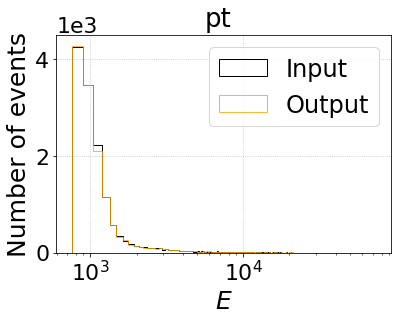

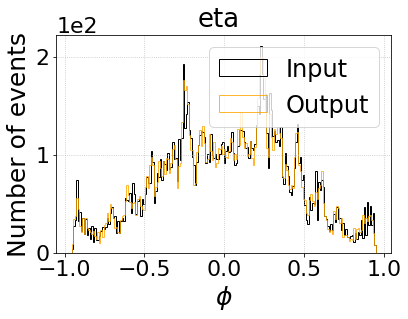

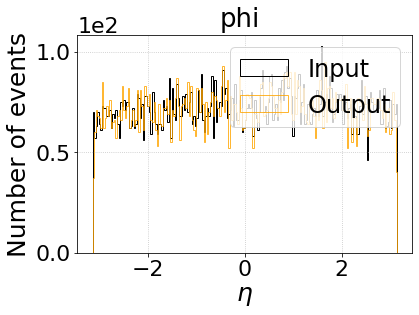

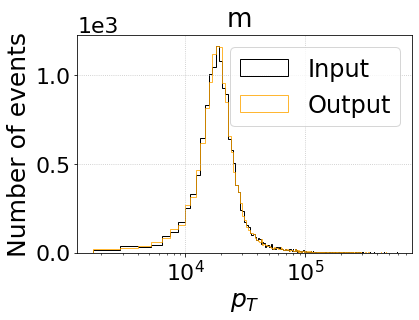

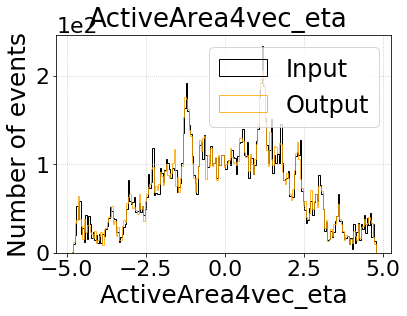

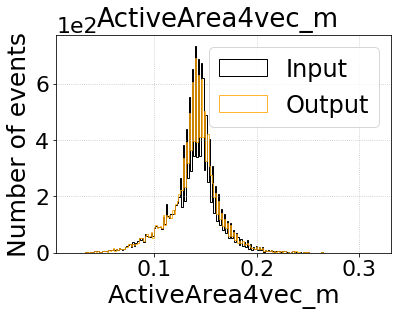

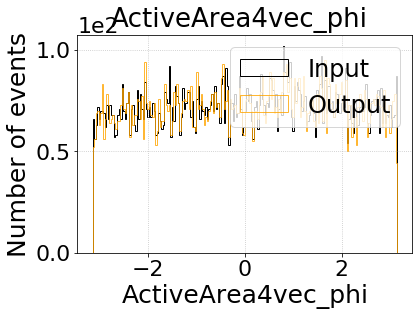

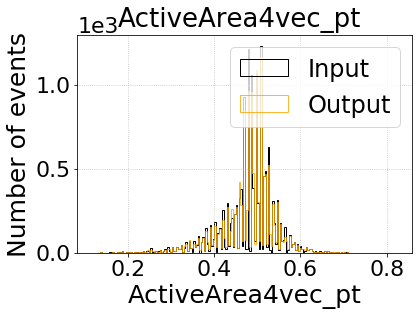

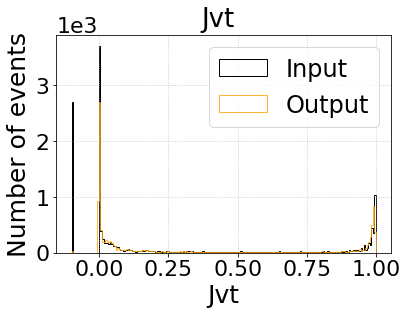

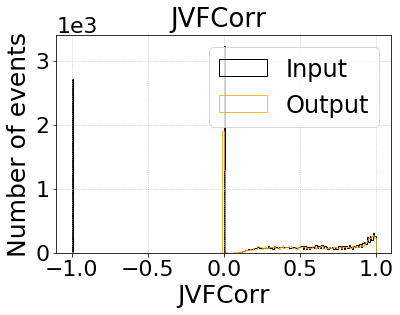

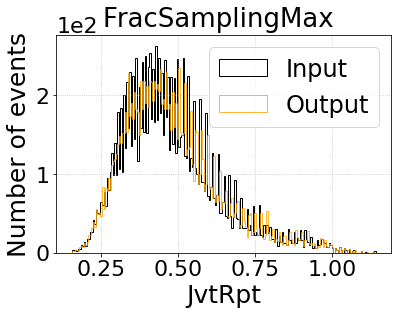

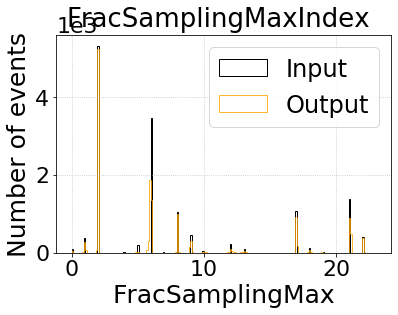

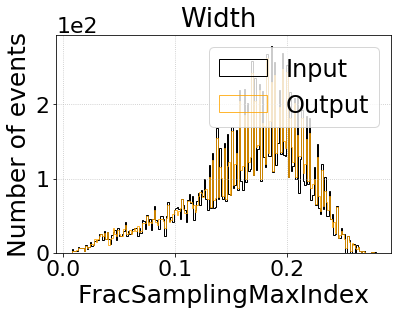

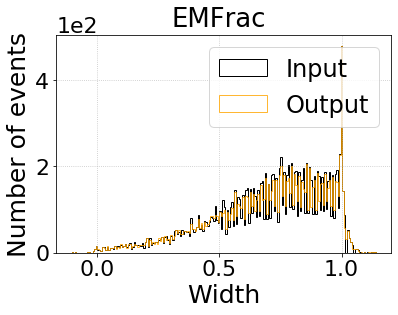

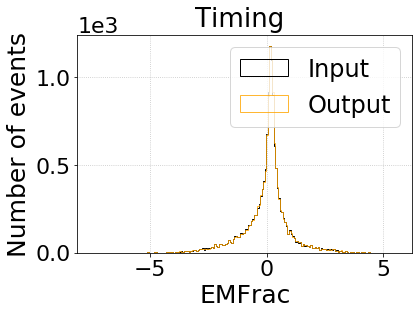

In [9]:
plt.close('all')
unit_list = ['[]', '[rad]', '[rad]', '[]']
variable_list = [r'$E$', r'$\phi$', r'$\eta$', r'$p_T$',"ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]
line_style = ['--', '-']
colors = ['orange', 'c']
markers = ['*', 's']

#model.to('cpu')
learn.load('compressed_15_10_15')

# Histograms
idxs = (0, 100000)  # Choose events to compare
data = torch.tensor(test_x[idxs[0]:idxs[1]].values)
#data = torch.tensor(test_x.values)

pred = model(data).detach().numpy()

#pred = np.multiply(pred, train_std.values)
#pred = np.add(pred, train_mean.values)
"""
#pred[:, 3] = np.power(10,pred[:, 3]*3.)#pred[3].apply(lambda x: np.e**(x*3.))
#pred[:, 0] = np.power(10,pred[:, 0]*3.)#pred[0].apply(lambda x: np.e**(x*3.))
pred[:, 0] = pred[:, 0] * 3000.
pred[:, 3] = pred[:, 3] * 3000.
pred[:, 1] = pred[:, 1] * 3.
pred[:, 2] = pred[:, 2] * 3.

data = np.multiply(data, train_std.values)
data = np.add(data, train_mean.values)

#data[:, 3] = np.power(10,data[:, 3]*3.)#.apply(lambda x: np.e**(x*3.))
#data[:, 0] = np.power(10,data[:, 0]*3.)#data[0].apply(lambda x: np.e**(x*3.))
data[:, 1] = data[:, 1] * 3.
data[:, 2] = data[:, 2] * 3.
data[:, 3] = data[:, 3] * 3000.
data[:, 0] = data[:, 0] * 3000.
"""

"""
for d in [data,pred]:
    #d[:, 0] = 10**(d[:, 0] * m_div) - m_add
    d[:, 0] = np.power(10, m_div * d[:, 0]) - m_add
    d[:, 3] = d[:, 3] * eta_div
    d[:, 2] = d[:, 2] * phi_div
    d[:, 1] = np.power(10, pt_div * d[:, 1] + pt_sub)
"""
"""
for d in [data,pred]:
    #d[:, 0] = (np.power(10, (d[:, 0] -1.1)*m_div))*3000

    d[:, 3] = d[:, 3] * eta_div
    d[:, 2] = d[:, 2] * phi_div
    
    d[:, 1] = (np.power(10, d[:, 1])+1)
"""

print(means)

branches = ["m","pt","phi","eta","ActiveArea4vec_eta", "ActiveArea4vec_m", "ActiveArea4vec_phi", "ActiveArea4vec_pt", "Jvt", "JVFCorr" ,"JvtRpt", "FracSamplingMax", "FracSamplingMaxIndex", "Width", "EMFrac","Timing"]

for d in [data,pred]:
    #data['m'] = (np.log10(data['m'])-3.6)
    
    d[:, 3] = np.power(10,(d[:, 3]+1.4)*m_div)-m_add
    
    d[:, 3] = d[:, 3] * eta_div
    
    d[:, 2] = d[:, 2] *phi_div
    
    d[:, 0] = np.power(10,(d[:, 0]+2.4)*pt_div)+pt_sub

    #d[:, 4] = (d[:, 4]*stds[0])+means[0]
    kk = 0
    while kk < len(means)-1:
        d[:, 4+kk] = (d[:, 4+kk]*stds[kk])+means[kk]
        kk+=1


alph = 0.8
n_bins = 200
for kk in np.arange(15):
    plt.figure(kk + 15)
    if kk == 0 or kk == 3:
        plt.xscale('log')
        n_bins = 500
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color='black', label='Input', alpha=1, bins=n_bins,histtype='step')
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color='orange', label='Output', alpha=alph, bins=bin_edges,histtype='step')
    plt.suptitle(train_x.columns[kk])
    plt.xlabel(variable_list[kk])# + ' ' + unit_list[kk])
    plt.ylabel('Number of events')
    ms.sciy()
    if kk == 0 or kk == 3:
        plt.xscale('log')
    # plt.yscale('log')
    plt.legend()
    fig_name = 'trainforever_hist_%s' % train.columns[kk]
    n_bins = 200
    #plt.savefig(curr_save_folder + fig_name)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


[1980.265544  852.398607 1046.20191   940.447089 ...  843.387833  809.574715 1217.588309 1038.966371]
[1951.519763  976.409882 1040.561848  976.409882 ...  841.690753  867.35154  1239.432942  989.240275]


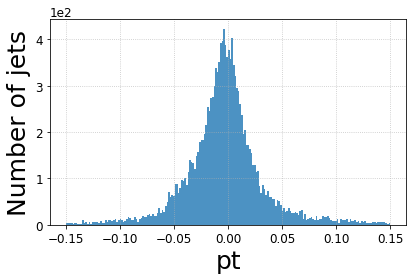

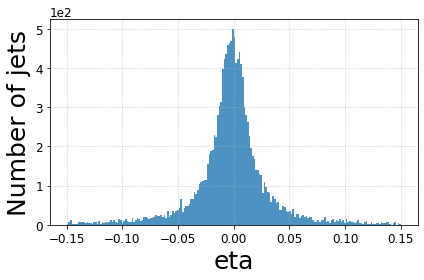

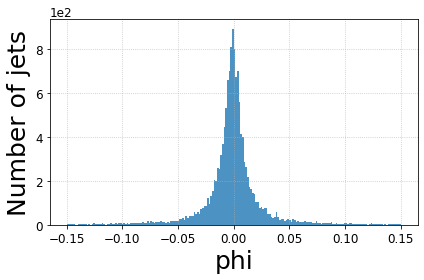

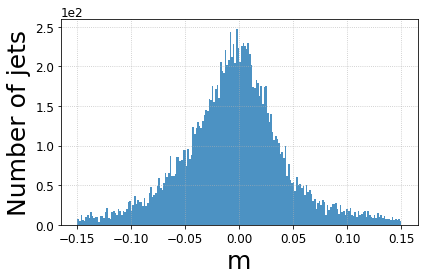

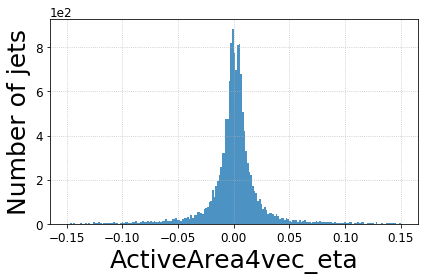

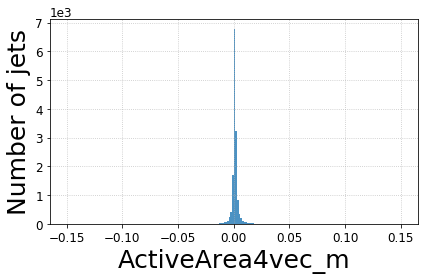

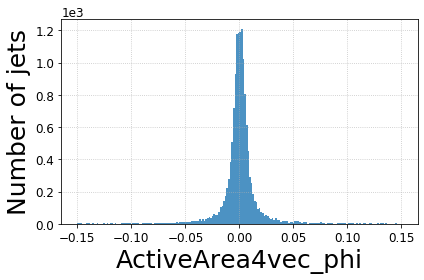

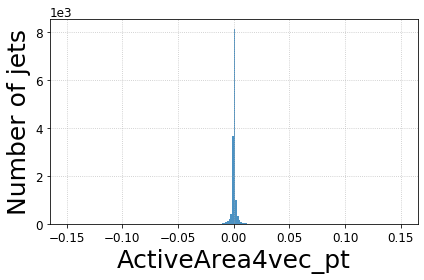

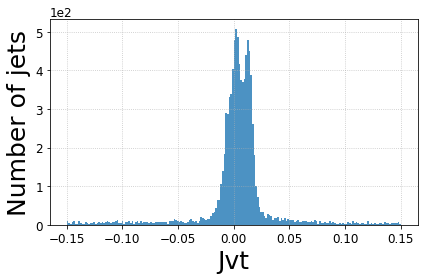

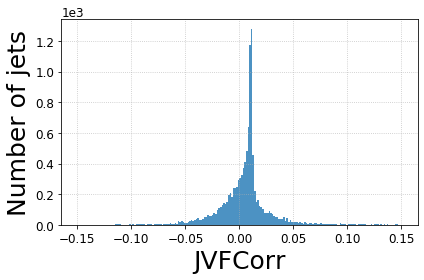

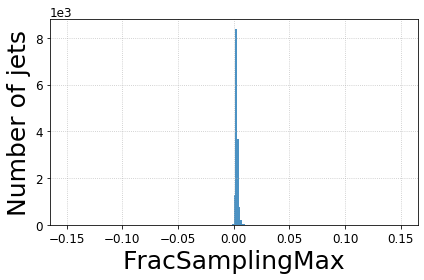

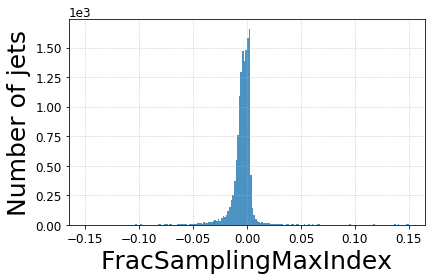

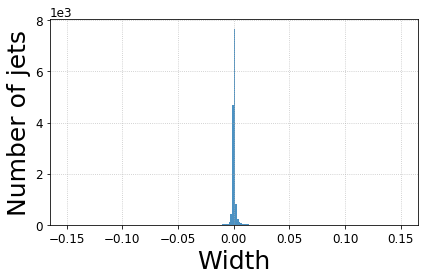

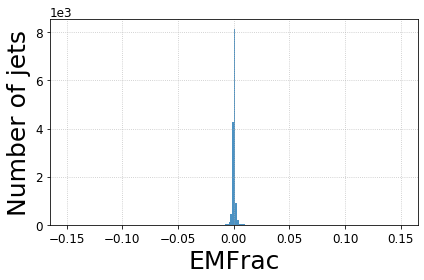

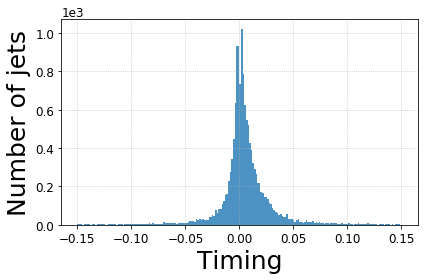

In [51]:
import utils
from scipy import stats
residual_strings = [r'$(m_{out} - m_{in}) / m_{in}$',
                    r'$(p_{T,out} - p_{T,in}) / p_{T,in}$',
                    r'$(\phi_{out} - \phi_{in}) / \phi_{in}$',
                        r'$(\eta_{out} - \eta_{in}) / \eta_{in}$'
                        
                        ]
#residuals = (pred - data.detach().numpy()) / data.detach().numpy()


residuals = (pred - data.detach().numpy())/data.detach().numpy()

mres = (pred[:, 0] - data.detach().numpy()[:, 0])/data.detach().numpy()[:, 0]

print(pred[:, 0])
print(data.detach().numpy()[:, 0])

axisrange = (-0.15, 0.15)
#range=None

for kk in np.arange(15):
    plt.figure()
    n_hist_pred, bin_edges, _ = plt.hist(
        residuals[:, kk], label='Residuals', linestyle=line_style[0], alpha=alph, bins=200, range=axisrange)
    #plt.suptitle('Residuals of %s' % train.columns[kk])
    plt.xlabel(train.columns[kk])  # (train.columns[kk], train.columns[kk], train.columns[kk]))
    plt.ylabel('Number of jets')
    ms.sciy()
    #plt.yscale('log')
    std = np.std(residuals[:, kk])
    std_err = utils.std_error(residuals[:, kk])
    mean = np.nanmean(residuals[:, kk])
    sem = stats.sem(residuals[:, kk], nan_policy='omit')
    ax = plt.gca()
    #plt.text(.75, .8, 'Mean = %f$\pm$%f\n$\sigma$ = %f$\pm$%f' % (mean, sem, std, std_err), bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10},
    #         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=18)
    fig_name = '15_10_residuals' + train.columns[kk]
    plt.tight_layout()
    plt.savefig(fig_name, dpi=300)

[(-0.015729057763485255, 0.016639452216317942), (-0.018276772897180132, 0.024303866022613925), (-1.4447415305916154, 1.3671723123870707), (-0.1998129534964892, 0.22781288698797547)]


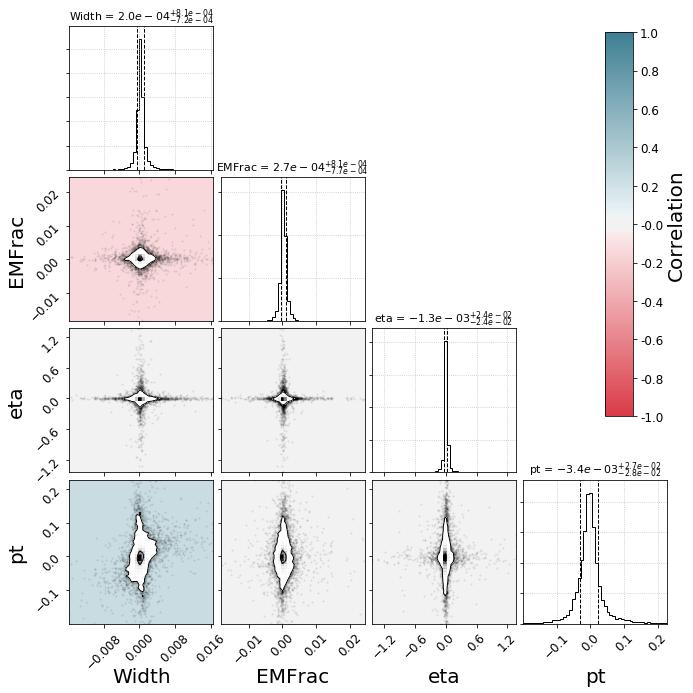

In [50]:
import corner.corner as corner
import seaborn as sns

res_df = pd.DataFrame({'Width': residuals[:, 12],'EMFrac': residuals[:, 13], 'eta': residuals[:, 1],'pt': residuals[:, 0]})
save = True
curr_save_folder = ""

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)
#cmap = 'RdBu'
norm = mpl.colors.Normalize(vmin=-1, vmax=1, clip=False)
mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

group = ['Width','EMFrac','eta','pt']

label_kwargs = {'fontsize': 20}
title_kwargs = {"fontsize": 11}
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
group_arr = res_df.values
corr = res_df.corr()
qs = np.quantile(group_arr, q=[.0025, .9975], axis=0)
ndim = qs.shape[1]
ranges = [tuple(qs[:, kk]) for kk in np.arange(ndim)]

print(ranges)
        
figure = corner(group_arr, range=ranges, plot_density=True, plot_contours=True, no_fill_contours=False, #range=[range for i in np.arange(ndim)],
                bins=50, labels=group, label_kwargs=label_kwargs, #truths=[0 for kk in np.arange(qs.shape[1])],
                show_titles=True, title_kwargs=title_kwargs, quantiles=(0.16, 0.84),
                # levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.2e')
                levels=(1 - np.exp(-0.5), .90), fill_contours=False, title_fmt='.1e')
                

# # Extract the axes
axes = np.array(figure.axes).reshape((ndim, ndim))
# Loop over the diagonal
linecol = 'r'
linstyl = 'dashed'
# Loop over the histograms
for yi in np.arange(ndim):
    for xi in np.arange(yi):
        ax = axes[yi, xi]
        # Set face color according to correlation
        ax.set_facecolor(color=mappable.to_rgba(corr.values[yi, xi]))
cax = figure.add_axes([.87, .4, .04, 0.55])
cbar = plt.colorbar(mappable, cax=cax, format='%.1f', ticks=np.arange(-1., 1.1, 0.2))
cbar.ax.set_ylabel('Correlation', fontsize=20)

if save:
    fig_name = 'corner_3.png'
    plt.savefig(curr_save_folder + fig_name, dpi=300)